# Play with Results!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from models.mol_autoencoder import MoleculeEncoder, MoleculeGraphDecoder
from models.word_autoencoder import WordEncoder, WordDecoder
from models.joint_autoencoder import JointAutoencoder
from transformers import BertTokenizer
from models.dataset import SMILES_CHARSET, PairedDataset

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

word_encoder = WordEncoder(latent_dim=768)
word_decoder = WordDecoder(latent_dim=768, vocab_size=tokenizer.vocab_size)
mol_encoder = MoleculeEncoder(input_dim=2048, hidden_dim=1024, latent_dim=768)
mol_decoder = MoleculeGraphDecoder(
    latent_dim=768, hidden_dim=1024, smiles_len=256, nchar=len(SMILES_CHARSET)
)

model = JointAutoencoder(
    word_encoder,
    word_decoder,
    mol_encoder,
    mol_decoder,
)


checkpoint_path = '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/Chemical_Language(Glucose for now)/checkpoints/joint-autoencoder-epoch=88-combined_loss=0.01.ckpt'
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into the model
model.load_state_dict(checkpoint['state_dict'])

/opt/anaconda3/envs/nlp_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<All keys matched successfully>

In [3]:
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import DataLoader

DATA_FILE = "datasets/playground_dataset.csv"
data_df = pd.read_csv(DATA_FILE)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = PairedDataset(DATA_FILE, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

/opt/anaconda3/envs/nlp_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
import pdb
import numpy as np
model.word_encoder.eval()
model.word_decoder.eval()
total = 10
for idx, batch in enumerate(dataloader):
    print("new batch", idx)
    print('input words ', batch["word"])
    # print(batch["word_input_ids"])
    # print(batch["word_attention_mask"].shape)
    # print(batch["encoded_smiles"].shape)
    # print(batch["morgan_fingerprints"].shape)

    # latent = model.word_encoder(batch["word_input_ids"], batch["word_attention_mask"])
    latent = model.mol_encoder(batch["morgan_fingerprints"])
    decoded_sentence, word_reconstruction_decoded = model.word_decoder.decode(latent, tokenizer)

    print('decoded words ', decoded_sentence)
    print('')
    total -= 1
    if total <= 0:
        break


new batch 0
input words  ['garden', 'freight', 'present', 'fowl', 'palace', 'sepulchre', 'folklore', 'founder', 'sitter', 'composer', 'psaltery', 'counsellor', 'expenditure', 'tie', 'neighbourhood', 'poison', 'pitcher', 'fund', 'renaissance', 'budget', 'rector', 'copper', 'debt', 'beach', 'author', 'voltage', 'growth', 'destroyer', 'martyr', 'men', 'canal', 'theology']
decoded words  ['##et', 'appeal', 'present', 'ab', 'fort', 'amul', 'folklore', 'founder', 'headster', 'composer', 'all', 'headslor', 'expenditure', 'tie', 'neighbourhood', 'poison', 'pitcher', 'fund', 'renaissance', 'budget', 'rector', 'oxygen', 'debt', 'laboratory', 'novelist', 'voltage', 'growth', 'destroyer', 'martyr', 'men', 'canal', 'theology']

new batch 1
input words  ['swimming', 'disposal', 'entertainment', 'orchestra', 'cottage', 'difference', "isn't", 'doth', 'bronze', 'platform', 'bedroom', 'singer', 'home', 'army', 'commerce', 'removal', 'president', 'grass', 'motel', 'planning', 'hearse', 'stockholder', 'co

# LET'S SEE HOW THE MOLECULES WE DIDN'T HAVE WORD MAPPINGS FOR LOOK...

In [5]:
import json

mols_df = pd.read_csv("playground_enamine_fingerprints.csv")
mols_df["Morgan_fingerprint"] = mols_df["Morgan_fingerprint"].apply(json.loads)
mols_df

,Unnamed: 0,SMILES,ZINC_ID,Morgan_fingerprint,UMAP1,UMAP2
0,64344,CCI,EN300-18902,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.104984,-0.008901
1,67918,CCN,EN300-19583,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.370481,-4.714182
2,70676,CCS,EN300-20602,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12.498261,-6.164637
3,80053,CSSC,EN300-36043,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.521301,-0.038971
4,66461,CCCI,EN300-19282,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.042813,-0.044903
...,...,...,...,...,...,...
19995,9922,c1c(o[nH]c1=O)N,EN300-101038,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11.618433,1.512455
19996,353275,CNCC(=O)C1CCCC1,EN300-795556,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.406396,4.600706
19997,90880,CCC(C)C(=N)N.Cl,EN300-54760,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.380912,3.424624
19998,33129,C1C2CC(C1C=C2)N,EN300-135261,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.467515,-8.818482


In [24]:
from tqdm import tqdm


def process_batch(batch_df, model, tokenizer, mf_col, decoded_word_col):
    morgan_fingerprints = np.stack(batch_df[mf_col].values)
    morgan_fingerprints_tensor = torch.tensor(morgan_fingerprints, dtype=torch.float32)
    latent = model.mol_encoder(morgan_fingerprints_tensor)
    decoded_sentences, _word_reconstruction_decoded = model.word_decoder.decode(
        latent, tokenizer
    )
    batch_df.loc[:, decoded_word_col] = decoded_sentences
    return batch_df


def process_dataframe_in_batches(
    df,
    model,
    tokenizer,
    batch_size=256,
    mf_col="Morgan_fingerprint",
    decoded_word_col="Decoded_word",
):
    num_batches = int(np.ceil(len(df) / batch_size))
    processed_batches = []

    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        processed_batch = process_batch(
            batch_df, model, tokenizer, mf_col, decoded_word_col
        )
        processed_batches.append(processed_batch)

    return pd.concat(processed_batches, ignore_index=True)

In [ ]:
processed_df = process_dataframe_in_batches(mols_df, model, tokenizer)

print(processed_df.head())

In [8]:
from utils.clustering_utils import kmeans_clustering

molecular_fingerprints = np.array(processed_df["Morgan_fingerprint"].tolist())
molecule_clusters = kmeans_clustering(molecular_fingerprints, n_clusters=20)

processed_df["Cluster"] = molecule_clusters


In [10]:
from utils.viz_utills import create_interactive_plot

create_interactive_plot(
    processed_df,
    smiles_col="SMILES",
    x_col="UMAP1",
    y_col="UMAP2",
    hover_cols=["SMILES"],
    cluster_col="Cluster",
    words_col="Decoded_word",
)

## Can this model decode reactions? I think some sort of retrosynthesis would still be cool to break molecules down into components

Let's try Rhea https://www.rhea-db.org/help/download#Reactions

In [25]:
from utils.chemical_fingerprinting import get_single_molecule_embedding

rhea_df = pd.read_csv("datasets/rhea-reaction-smiles.tsv", header=None, delimiter="\t")

rhea_df = rhea_df[:2000]
rhea_df["Reagent"] = rhea_df[1].apply(lambda x: x.split(">>")[0])
rhea_df["Reagent_Morgan_Fingerprint"] = rhea_df["Reagent"].apply(
    lambda x: get_single_molecule_embedding(x)
)
rhea_df = process_dataframe_in_batches(
    rhea_df,
    model,
    tokenizer,
    mf_col="Reagent_Morgan_Fingerprint",
    decoded_word_col="Reagent_word",
)

rhea_df["Product"] = rhea_df[1].apply(lambda x: x.split(">>")[1])
rhea_df["Product_Morgan_Fingerprint"] = rhea_df["Product"].apply(
    lambda x: get_single_molecule_embedding(x)
)
rhea_df = process_dataframe_in_batches(
    rhea_df,
    model,
    tokenizer,
    mf_col="Product_Morgan_Fingerprint",
    decoded_word_col="Product_word",
)

rhea_df = rhea_df.drop(columns=[1])

[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not removing hydrogen atom without neighbors
[16:08:26] WARNING: not r

In [34]:
rhea_df

,0,Reagent,Reagent_Morgan_Fingerprint,Reagent_word,Product,Product_Morgan_Fingerprint,Product_word
0,10001,CCCCC(N)=O.[H]O[H],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",white,CCCCC(=O)[O-].[H][N+]([H])([H])[H],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",re
1,10002,CCCCC(=O)[O-].[H][N+]([H])([H])[H],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",re,CCCCC(N)=O.[H]O[H],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",white
2,10005,S=C=NCC1=CC=CC=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",radiation,N#CSCC1=CC=CC=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",pool
3,10006,N#CSCC1=CC=CC=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",pool,S=C=NCC1=CC=CC=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",famine
4,10009,*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O.*OO,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",##thalton,*N[C@@H](CSSC[C@H](N*)C(*)=O)C(*)=O.*O.[H]O[H],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",armnare
...,...,...,...,...,...,...,...
1995,14339,CC(=O)N[C@H]1[C@@H](OP(=O)([O-])OP(=O)([O-])OC...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",,CC(=O)N[C@H]1[C@@H](OP(=O)([O-])OP(=O)([O-])OC...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
1996,14342,O=C([O-])CCC(=O)C(=O)[O-].[H+].[H]C(=O)C(=O)[O-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",##eon,O=C([O-])CCC(=O)C(O)C(=O)[O-].O=C=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",re
1997,14343,O=C([O-])CCC(=O)C(O)C(=O)[O-].O=C=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",re,O=C([O-])CCC(=O)C(=O)[O-].[H+].[H]C(=O)C(=O)[O-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",##eon
1998,14346,[H+].[NH3+][C@@H](CC1=CC=C(O)C=C1)C(=O)[O-],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",##k,O=C=O.[NH3+]CCC1=CC=C(O)C=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",line


In [29]:
rhea_df.to_csv('datasets/processed_playground_rhea.csv')

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# Function to generate a molecule image
def smiles_to_image(smiles, filename):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        img = Draw.MolToImage(mol, size=(300, 300))
        img.save(filename)
        return img
    return None

def generate_reaction(rhea_df, starting_idx=0):
    # Generate images for each row in the dataframe
    images = []
    prev_product = rhea_df.iloc[starting_idx]['Reagent'] # initialize with first reagent for now
    print(prev_product)
    for index in range(starting_idx, len(rhea_df)):
        row = rhea_df.iloc[index]
        if prev_product != row["Reagent"]:
            print(row)
            print('we broke! ', prev_product != row["Reagent"])
            break
        reagent_image = smiles_to_image(row["Reagent"], f'reagent_{index}.png')
        product_image = smiles_to_image(row["Product"], f'product_{index}.png')
        images.append((reagent_image, row["Reagent_word"], row["Reagent"], product_image, row["Product_word"], row["Product"]))
        prev_product = row['Product']

    # Create a composite image with arrows and labels
    fig, axes = plt.subplots(len(images), 1, figsize=(8, len(images) * 4))
    for i, (reagent_img, reagent_word, reagent_smiles, product_img, product_word, product_smiles) in enumerate(images):
        axes[i].imshow(reagent_img)
        axes[i].axis('off')
        axes[i].text(-150, 100, f'{reagent_smiles}\n{reagent_word}', fontsize=10, ha='center')
        axes[i].arrow(320, 150, 80, 0, head_width=20, head_length=10, fc='k', ec='k')
        axes[i].imshow(product_img, extent=(400, 700, 0, 300))
        axes[i].text(850, 100, f'{product_smiles}\n{product_word}', fontsize=10, ha='center')

    plt.tight_layout()

In [74]:
def generate_reactions_v2(rhea_df, starting_idx=0):
    # Generate images for each unique molecule in the dataframe
    unique_molecules = {}
    ordered_molecules = []
    # initialize with first reagent 
    prev_product = rhea_df.iloc[starting_idx]['Reagent'] 
    ordered_molecules.append(prev_product)
    for index in range(starting_idx, len(rhea_df)):
        row = rhea_df.iloc[index]
        if prev_product != row["Reagent"]:
            break
        if row["Reagent"] not in unique_molecules:
            reagent_filename = f'reagent_{index}.png'
            reagent_img = smiles_to_image(row["Reagent"], reagent_filename)
            unique_molecules[row["Reagent"]] = (reagent_img, row["Reagent_word"], row["Reagent"], reagent_filename)
        if row["Product"] not in unique_molecules:
            product_filename = f'product_{index}.png'
            product_img = smiles_to_image(row["Product"], product_filename)
            unique_molecules[row["Product"]] = (product_img, row["Product_word"], row["Product"], product_filename)
        prev_product = row["Product"]
        ordered_molecules.append(prev_product)

    print(ordered_molecules)

    # Create a composite image with three molecular images per row
    fig, axes = plt.subplots(len(ordered_molecules) // 3 + 1, 3, figsize=(18, (len(ordered_molecules) // 3 + 1) * 6))
    axes = axes.flatten()

    for i, mol in enumerate(ordered_molecules):
        img, word, smiles, filename = unique_molecules[mol]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].text(150, 320, f'{smiles}\n{word}', fontsize=10, ha='center')

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('reaction_pathway.png')
    plt.show()


['CCCCC(N)=O.[H]O[H]', 'CCCCC(=O)[O-].[H][N+]([H])([H])[H]', 'CCCCC(N)=O.[H]O[H]']


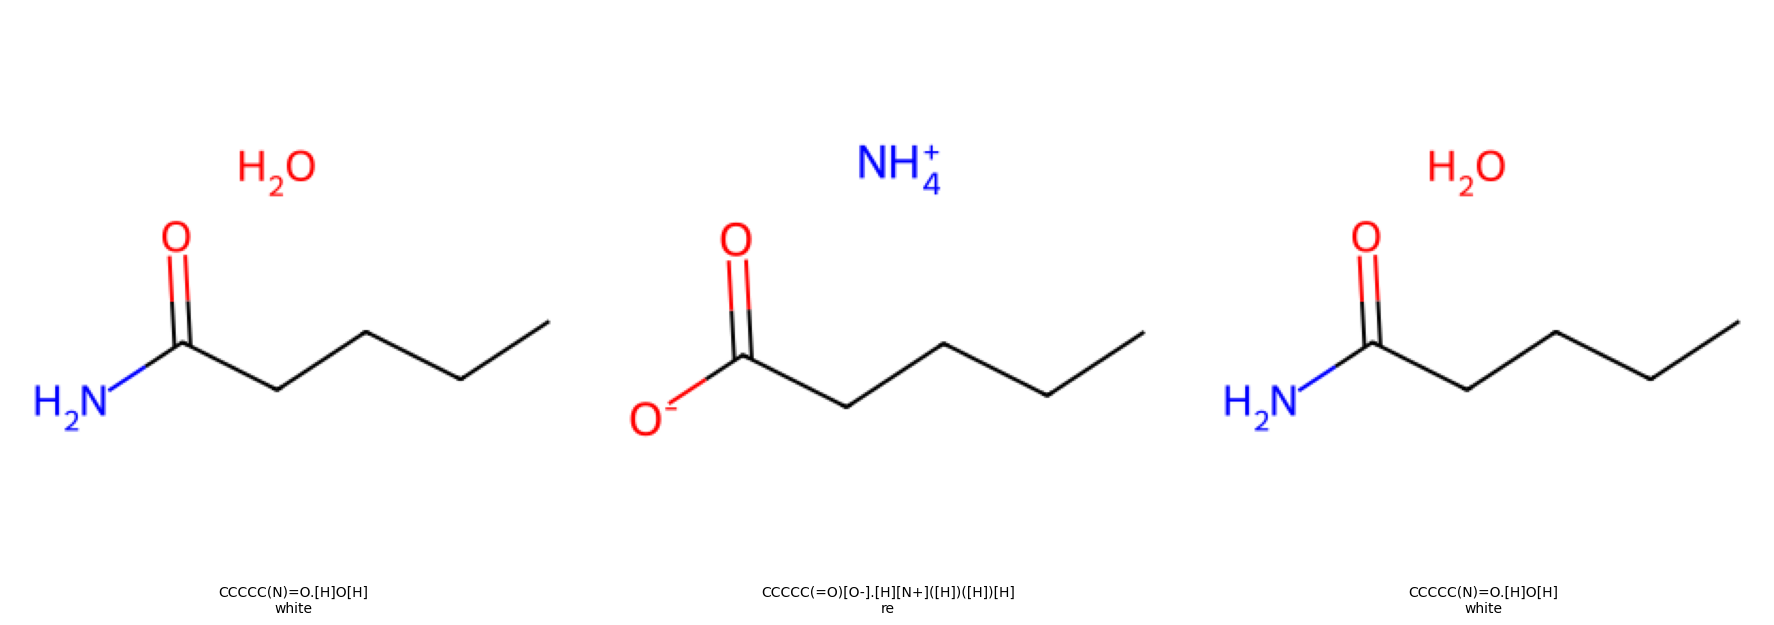

In [75]:
generate_reactions_v2(rhea_df=rhea_df, starting_idx=0)

['S=C=NCC1=CC=CC=C1', 'N#CSCC1=CC=CC=C1', 'S=C=NCC1=CC=CC=C1']


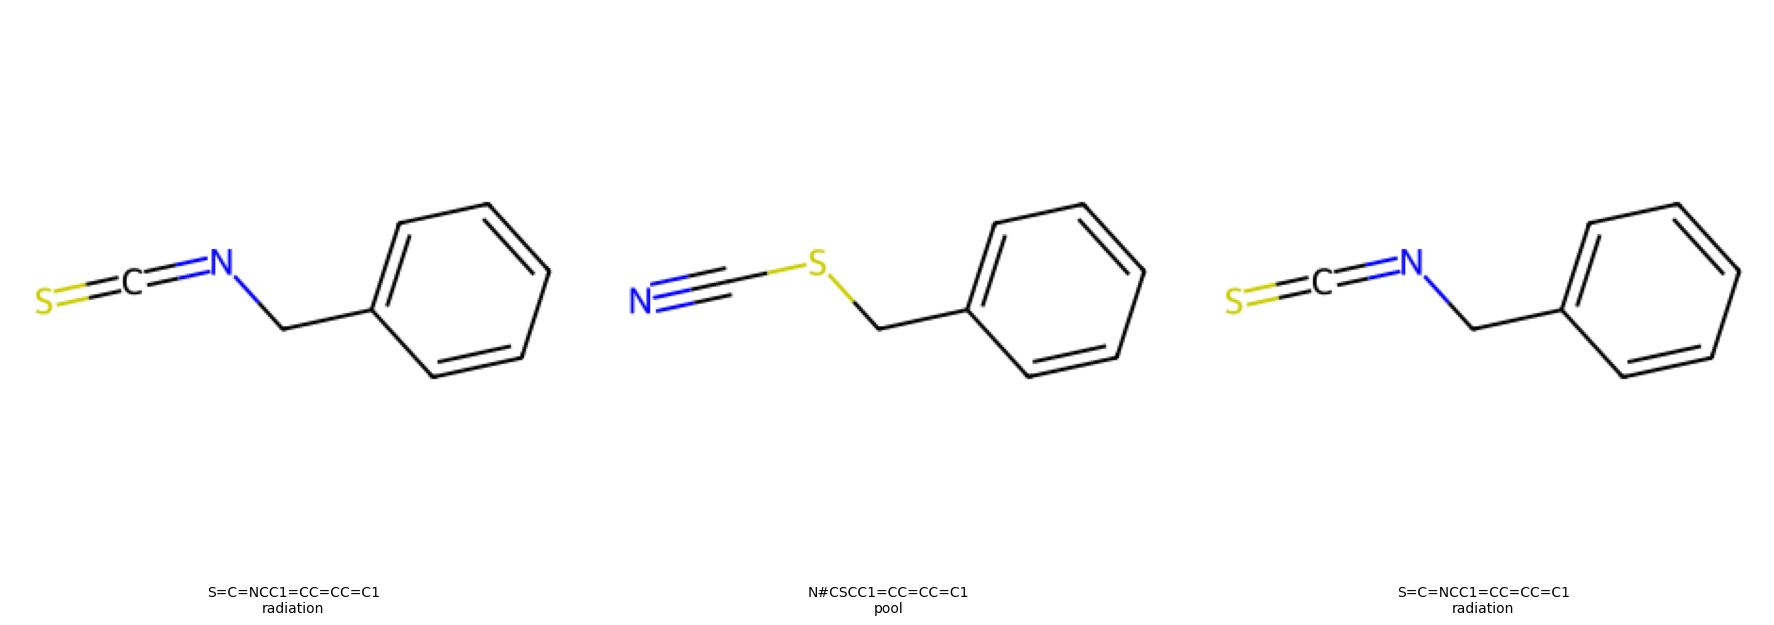

In [76]:
generate_reactions_v2(rhea_df=rhea_df, starting_idx=2)

['*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O.*OO', '*N[C@@H](CSSC[C@H](N*)C(*)=O)C(*)=O.*O.[H]O[H]', '*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O.*OO']


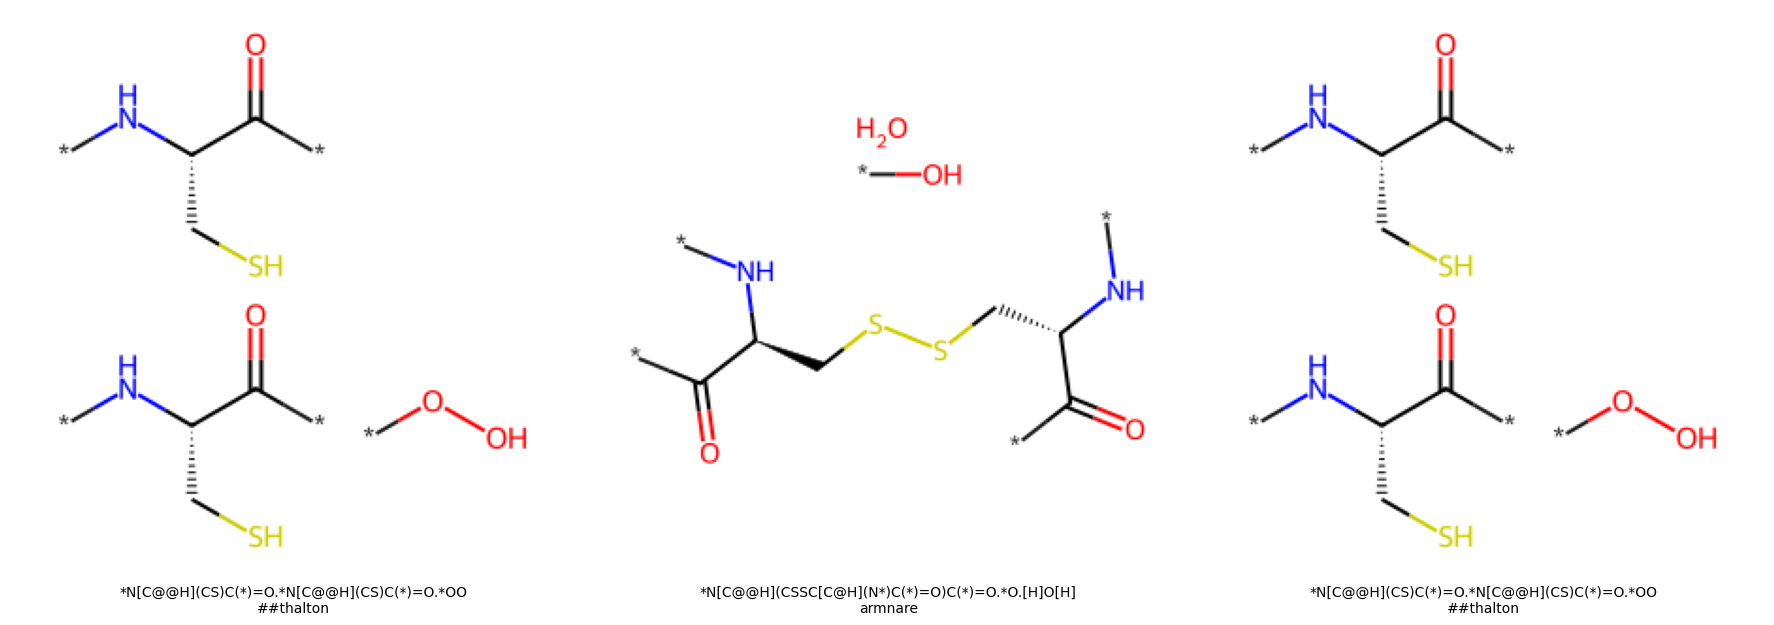

In [77]:
generate_reactions_v2(rhea_df=rhea_df, starting_idx=4)

['O=O.[H]O[H].[H][C@]1(C2=CN=C(O)C=C2)CCC[NH+]1C', 'C[NH2+]CCCC(=O)C1=CN=C(O)C=C1.[H]OO[H]', 'O=O.[H]O[H].[H][C@]1(C2=CN=C(O)C=C2)CCC[NH+]1C']


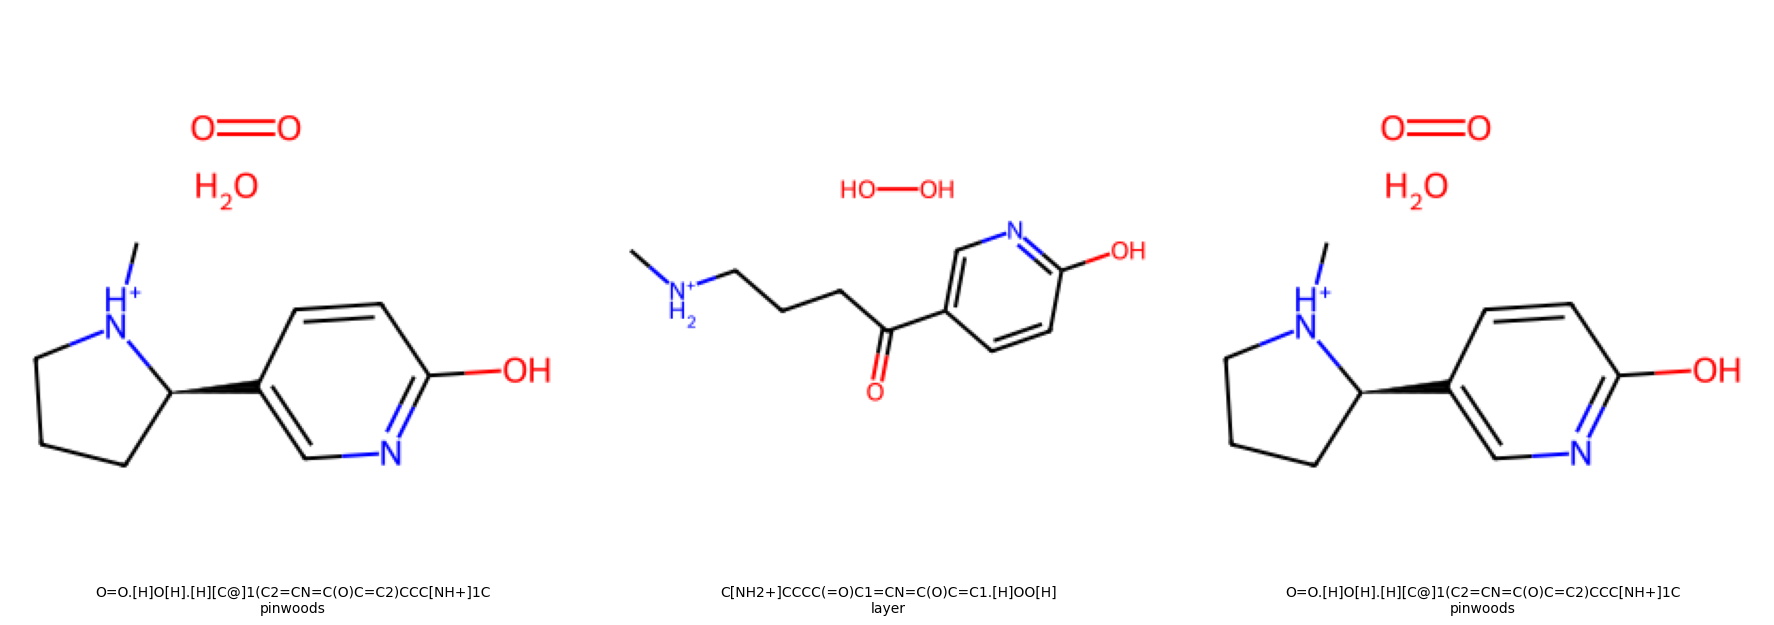

In [78]:
generate_reactions_v2(rhea_df=rhea_df, starting_idx=6)

[16:38:03] WARNING: not removing hydrogen atom without neighbors
/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_74316/1312776741.py:39: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations



['CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](N3C=NC4=C3N=CN=C4N)[C@H](O)[C@@H]1O)C1=NC(=O)[N-]C(=O)C1=N2.C[NH2+]C.[H+].[H]O[H]', 'CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](N3C=NC4=C3N=CN=C4N)[C@H](O)[C@@H]1O)C1=C(N2)C(=O)NC(=O)N1.C[NH3+].[H]C([H])=O', 'CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](N3C=NC4=C3N=CN=C4N)[C@H](O)[C@@H]1O)C1=NC(=O)[N-]C(=O)C1=N2.C[NH2+]C.[H+].[H]O[H]']


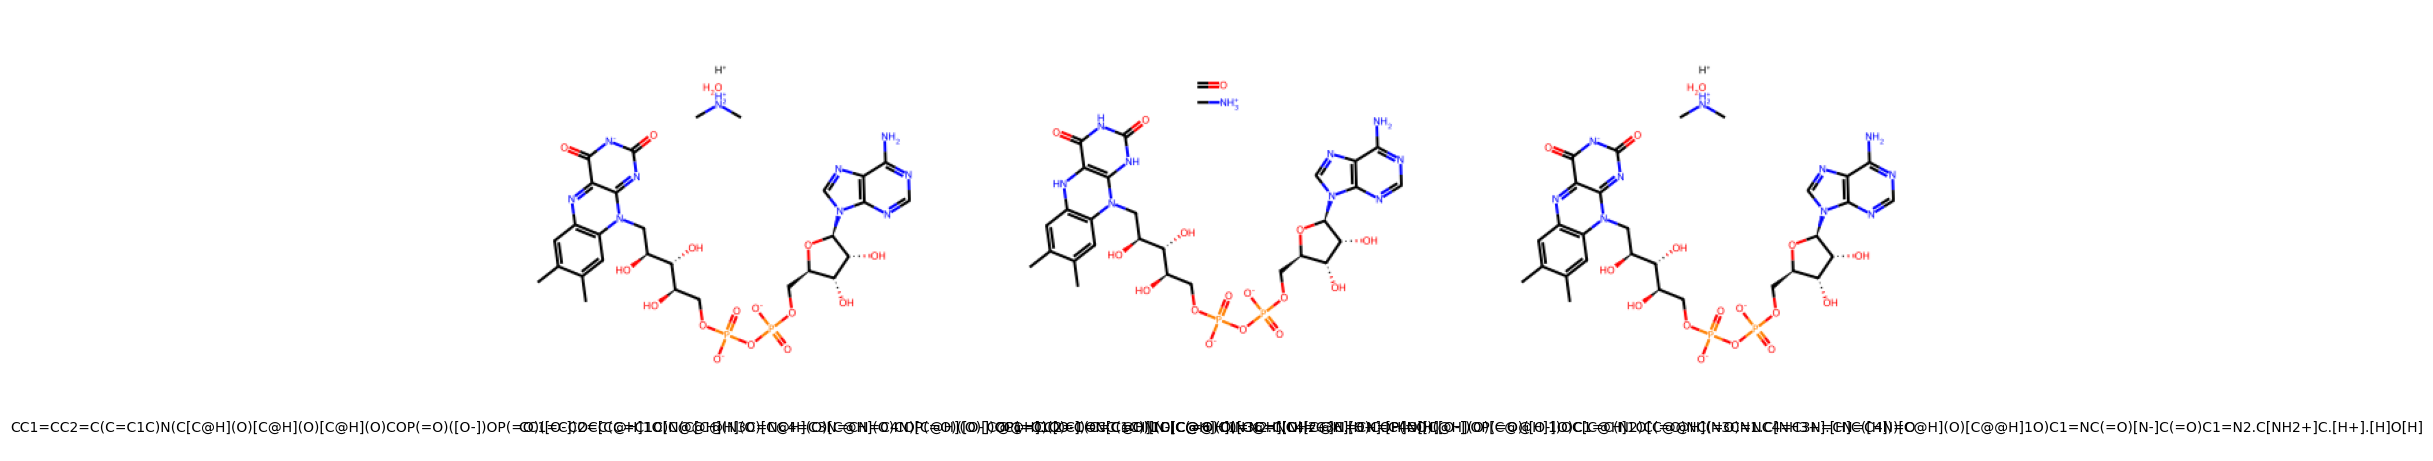

In [87]:
generate_reactions_v2(rhea_df=rhea_df, starting_idx=100)

Let's try metabolic pathways from https://metacyc.org/

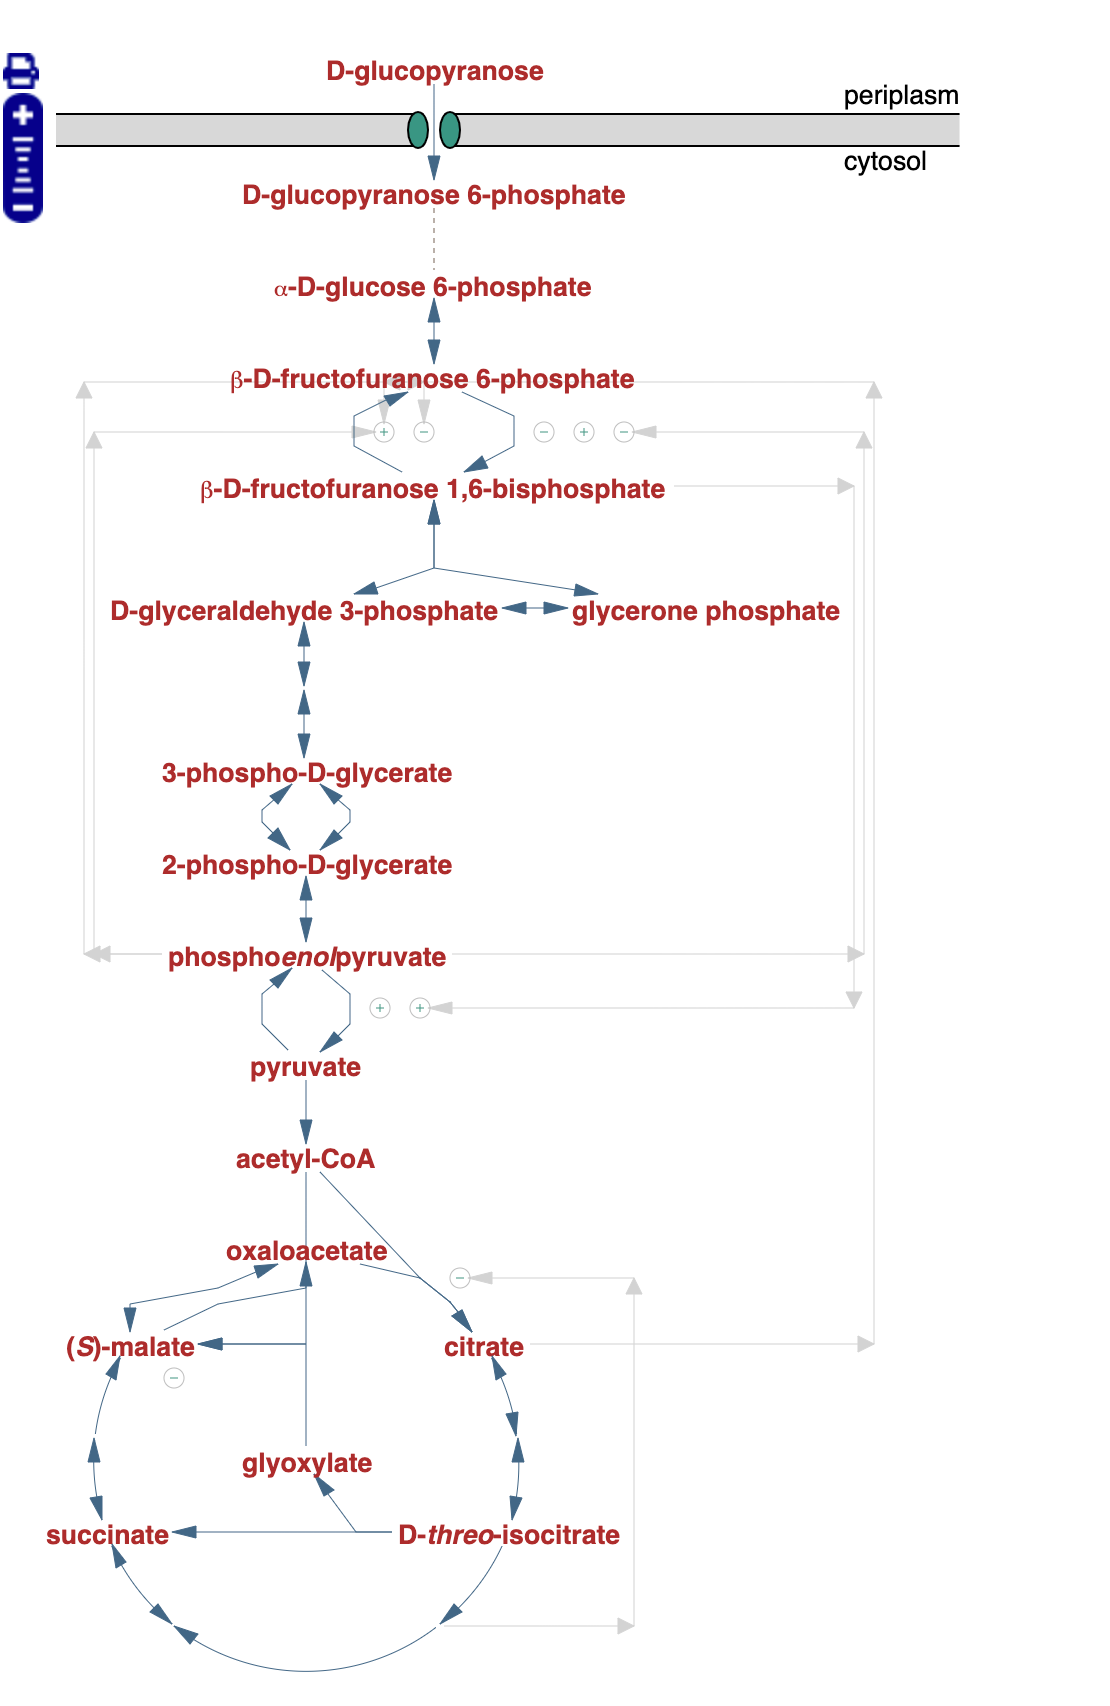

In [ ]:
# TODO: I don't trust these smiles
GLYOCLYSIS_SMILES = [  # D-Glucopyranose
    "OC[C@@H]1OC(O)C@HC@@H[C@@H]1O", # "OC[C@@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O",
    # D-Glucopyranose 6-phosphate
    "OC[C@@H]1OC(O)C@HC@@H[C@@H]1O",
    # α-D-Glucose 6-phosphate
    "OC[C@@H]1OC(O)C@HC@@H[C@@H]1O",
    # β-D-Fructofuranose 6-phosphate
    "OC[C@@H]1OC@HC@HC@@H[C@H]1O",
    # β-D-Fructofuranose 1,6-bisphosphate
    "OC[C@@H]1OC@HC@HC@@H[C@H]1OP(=O)(O)O",
    # D-Glyceraldehyde 3-phosphate
    "OCC(C=O)OP(=O)(O)O",
    # Glycerone phosphate (Dihydroxyacetone phosphate)
    "OCC(=O)COP(=O)(O)O",
    # 3-Phospho-D-glycerate
    "OC@HC(=O)COP(=O)(O)O",
    # 2-Phospho-D-glycerate
    "OC@HC(=O)O",
    # Phosphoenolpyruvate
    "OC@HC=O",
    # Pyruvate
    "CC(=O)C(=O)O",
]

In [ ]:
from utils.chemical_fingerprinting import get_single_molecule_embedding

rhea_df = pd.DataFrame()
rhea_df['Reagent'] = GLYOCLYSIS_SMILES

rhea_df = rhea_df[:2000]
rhea_df["Reagent"] = rhea_df[1].apply(lambda x: x.split(">>")[0])
rhea_df["Reagent_Morgan_Fingerprint"] = rhea_df["Reagent"].apply(
    lambda x: get_single_molecule_embedding(x)
)
rhea_df = process_dataframe_in_batches(
    rhea_df,
    model,
    tokenizer,
    mf_col="Reagent_Morgan_Fingerprint",
    decoded_word_col="Reagent_word",
)

rhea_df["Product"] = rhea_df[1].apply(lambda x: x.split(">>")[1])
rhea_df["Product_Morgan_Fingerprint"] = rhea_df["Product"].apply(
    lambda x: get_single_molecule_embedding(x)
)
rhea_df = process_dataframe_in_batches(
    rhea_df,
    model,
    tokenizer,
    mf_col="Product_Morgan_Fingerprint",
    decoded_word_col="Product_word",
)

rhea_df = rhea_df.drop(columns=[1])